In [1]:
import pandas as pd
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from glob import glob
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, GlobalAveragePooling2D, Dense, Dropout, Flatten, Activation, BatchNormalization
import cv2
import pickle
from scipy.ndimage import median_filter, convolve
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from sklearn.metrics import classification_report,confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from keras import applications

sys.version

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'3.6.9 (default, Jul 17 2020, 12:50:27) \n[GCC 8.4.0]'

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
data_dir = "/content/drive/My Drive/flowers"

categories = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [9]:
# przygotowanie i zaczytanie danych
data = []
def make_data():
    for category in categories:
        path = os.path.join(data_dir, category)
        label = categories.index(category)
        
        for img_name in os.listdir(path):
            image_path = os.path.join(path, img_name)
            image = cv2.imread(image_path)
            
            try:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (224,224))
                
                image = np.array(image, dtype=np.float32)
                
                data.append([image, label])
            except Exception as e:
                pass
    print(len(data))
    
    pik = open('data.pickle', 'wb')
    pickle.dump(data,pik)
    pik.close()

In [10]:
make_data()

4323


In [11]:
def load_data():
    pick = open('data.pickle','rb')
    data = pickle.load(pick)
    pick.close()
    
    np.random.shuffle(data)
    
    feature = []
    labels = []
    
    for img, label in data:
        feature.append(img)
        labels.append(label)
        
    feature = np.array(feature, dtype=np.float32)
    labels = np.array(labels)
    
    feature = feature/255.0
    
    return [feature, labels]

In [12]:
(feature, labels) = load_data()

In [13]:
#preprocessing labelek 
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(labels)

In [14]:
x_train, x_test, y_train, y_test = train_test_split (feature, labels, test_size = 0.2, random_state = 0)

In [15]:
# dodatkowy podział danych testowych
X_test,X_valid, y_test, y_valid = train_test_split(x_test,y_test, test_size = 0.5)

In [16]:
#MODEL VGG16 z wagami imagenet jako model bazowy
#załadowanie modelu VGG16 bez ostatniej warstwy
base_model = applications.VGG16(weights='imagenet', include_top=False)
print('wczytano model!')

# zamrożenie pierwszych warstw (nie będą trenowane)
for layer in base_model.layers[:15]:
    layer.trainable = False
    
base_model.summary()

58892288/58889256 [==============================] - 1s 0us/step
wczytano model!
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________

In [17]:
# top_model dodawany do modelu bazowego 
top_model = Sequential()
top_model.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(5, activation='softmax')) 
top_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 2565      
Total params: 2,565
Trainable params: 2,565
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Połączenie modeli base i top
model = Sequential()
model.add(base_model)
model.add(top_model)
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
sequential (Sequential)      (None, 5)                 2565      
Total params: 14,717,253
Trainable params: 7,081,989
Non-trainable params: 7,635,264
_________________________________________________________________


In [19]:
# Trenowanie modelu z użyciem generatorów na 100 epokach
epochs = 100
batch_size=32
best_model_finetuned_path = 'best_finetuned_model.hdf5'

train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
    x_train, y_train,
    batch_size=batch_size)

validation_generator = test_datagen.flow(
    X_valid,y_valid,
    batch_size=batch_size)

checkpointer = ModelCheckpoint(best_model_finetuned_path,save_best_only = True,verbose = 1)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(x_train) // batch_size,
    epochs= epochs,
    validation_data=validation_generator,
    validation_steps=len(X_valid) // batch_size,
    callbacks=[checkpointer])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
108/108 [==============================] - ETA: 0s - loss: 1.4956 - accuracy: 0.3876
Epoch 00001: val_loss improved from inf to 1.36478, saving model to best_finetuned_model.hdf5
108/108 [==============================] - 41s 375ms/step - loss: 1.4956 - accuracy: 0.3876 - val_loss: 1.3648 - val_accuracy: 0.5553
Epoch 2/100
108/108 [==============================] - ETA: 0s - loss: 1.2185 - accuracy: 0.5788
Epoch 00002: val_loss improved from 1.36478 to 1.07008, saving model to best_finetuned_model.hdf5
108/108 [==============================] - 42s 390ms/step - loss: 1.2185 - accuracy: 0.5788 - val_loss: 1.0701 - val_accuracy: 0.6490
Epoch 3/100
108/108 [==============================] - ETA: 0s - loss: 0.9630 - accuracy: 0.6730
Epoch 00003: val_loss improved from 1.07008 to 0.87176, saving model to best_finetuned_model.hdf5
108/108 [==============================] - 41s 383ms/step - loss: 0.9630 - 

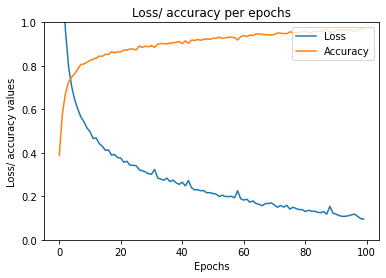

In [38]:
#wykres zmian wartości loss, accuracy poprzez epoki
plt.plot(history.history["loss"], label = 'Loss') 
plt.plot(history.history['accuracy'], label = 'Accuracy')
plt.ylim(0, 1)
plt.legend(loc = 'upper right')
plt.title("Loss/ accuracy per epochs")
plt.ylabel('Loss/ accuracy values')
plt.xlabel('Epochs')
plt.show()

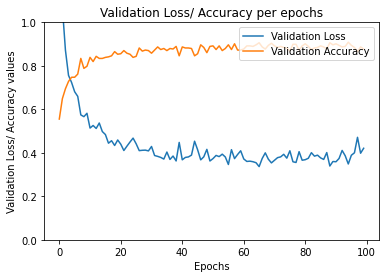

In [39]:
#wykres zmian wartości loss, accuracy  poprzez epoki
plt.plot(history.history["val_loss"], label = 'Validation Loss') 
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.ylim(0, 1)
plt.legend(loc = 'upper right')
plt.title("Validation Loss/ Accuracy per epochs")
plt.ylabel('Validation Loss/ Accuracy values')
plt.xlabel('Epochs')
plt.show()

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [20]:
# ocena modelu
model.load_weights(best_model_finetuned_path)  
   
(eval_loss, eval_accuracy) = model.evaluate(  
     X_test, y_test, batch_size=batch_size, verbose=1)

print("Accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("Loss: {}".format(eval_loss)) 

14/14 [==============================] - 3s 184ms/step - loss: 0.4153 - accuracy: 0.8657
Accuracy: 86.57%
Loss: 0.4152967631816864


In [24]:
# zapisywanie modelu na komputer lokalnie
from google.colab import files
files.download('best_finetuned_model.hdf5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
# sprawdzenie wczytania samego wytrenowanego modelu już z pliku 
from google.colab import files
files.upload()

{}

In [ ]:
model = tf.keras.models.load_model('best_finetuned_model_92.hdf5')

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

In [ ]:
predictions = model.predict_classes(x_test)

In [ ]:
y_test_inv = label_binarizer.inverse_transform(y_test)

In [ ]:
# Classification Report
print(classification_report(y_test_inv, predictions, target_names = categories))

In [ ]:
#Confusion Matrix
cm = confusion_matrix(y_test_inv,predictions)
cm

In [ ]:
cm = pd.DataFrame(cm , index = categories , columns = categories)

In [ ]:
#Heatmapa Confusion Matrix
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = categories , yticklabels = categories)

In [ ]:
# przygotowanie do wizualizacji predykcji
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test_inv)):
    if(y_test_inv[i] == predictions[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test_inv)):
    if(y_test_inv[i] != predictions[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

In [ ]:
#Prawidłowe predykcje
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+ categories[predictions[prop_class[count]]] +"\n"+"Actual Flower : "+ categories[y_test_inv[prop_class[count]]])
        plt.tight_layout()
        count+=1

In [ ]:
# Błędne predykcje
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+categories[predictions[mis_class[count]]]+"\n"+"Actual Flower : "+categories[y_test_inv[mis_class[count]]])
        plt.tight_layout()
        count+=1

In [ ]:
# załadowanie obrazka z dysku
from google.colab import files
files.upload()

In [ ]:
# wczytanie obrazka z internetu
!wget https://4gift.pl/media/catalog/product/cache/1/thumbnail/600x/9df78eab33525d08d6e5fb8d27136e95/t/u/tulip-zaparzaczka-do-herbaty6.jpg

In [ ]:
# przerobienie obrazka
def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                   
    img_tensor = np.expand_dims(img_tensor, axis=0)        
    img_tensor /= 255.                                      

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

In [ ]:
#  załadowanie obrazka i sprawdzenie predykcji
img_path = 'tulip-zaparzaczka-do-herbaty6.jpg'
new_image = load_image(img_path)
img = cv2.imread('tulip-zaparzaczka-do-herbaty6.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
pred = model.predict(new_image)
print(pred.argmax())
print (categories[pred.argmax()])